In [407]:
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
import random
from datetime import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
# from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

In [408]:
df = pd.read_csv("/content/drive/MyDrive/AAPL.csv")

In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1257 non-null   object 
 1   date         1257 non-null   object 
 2   close        1257 non-null   float64
 3   high         1257 non-null   float64
 4   low          1257 non-null   float64
 5   open         1257 non-null   float64
 6   volume       1257 non-null   int64  
 7   adjClose     1257 non-null   float64
 8   adjHigh      1257 non-null   float64
 9   adjLow       1257 non-null   float64
 10  adjOpen      1257 non-null   float64
 11  adjVolume    1257 non-null   int64  
 12  divCash      1257 non-null   float64
 13  splitFactor  1257 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.6+ KB


In [410]:
df['close'].isnull().any()

False

In [411]:
df2 = pd.DataFrame(np.log(df['close']))
df2['date'] = pd.to_datetime(df['date']).dt.date

In [412]:
df2

,close,date
0,4.664665,2016-03-23
1,4.660321,2016-03-24
2,4.655768,2016-03-28
3,4.679164,2016-03-29
4,4.696472,2016-03-30
...,...,...
1252,4.820201,2021-03-15
1253,4.832863,2021-03-16
1254,4.826392,2021-03-17
1255,4.791899,2021-03-18


In [413]:
df2.set_index('date', inplace=True)

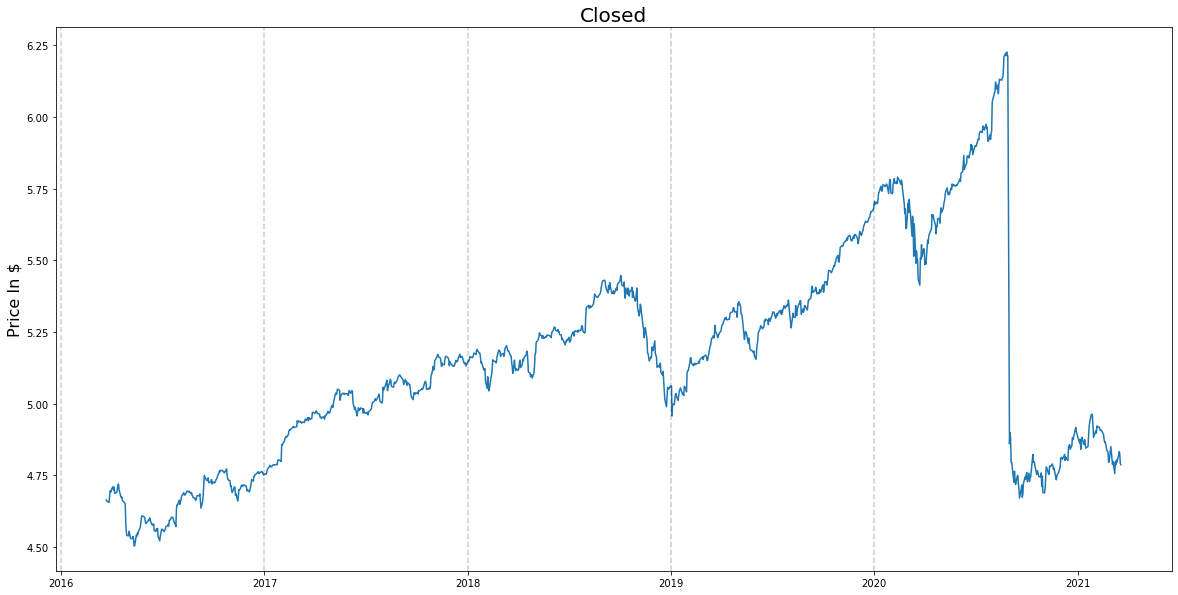

In [414]:
plt.figure(figsize=(20,10))
plt.plot(df2.close)
plt.title('Closed', fontsize=20)
plt.ylabel('Price In $', fontsize=16)
for year in range(2016,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [415]:
hypo1 = adfuller(df2.close)
print(hypo1)

(-2.190094045182718, 0.2098603718715582, 6, 1250, {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776}, -4258.202145300758)


In [416]:
first_diffs = df2.close - df2.close.shift(1)

In [417]:
df2['FirstDifference'] = first_diffs

In [418]:
df2.dropna(inplace=True)

In [419]:
hypo2 = adfuller(df2.FirstDifference)
print(hypo2)

(-14.410721338789184, 8.213462036815635e-27, 5, 1250, {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776}, -4252.97771704041)


In [420]:
# ndiffs(df2.close, test='adf')

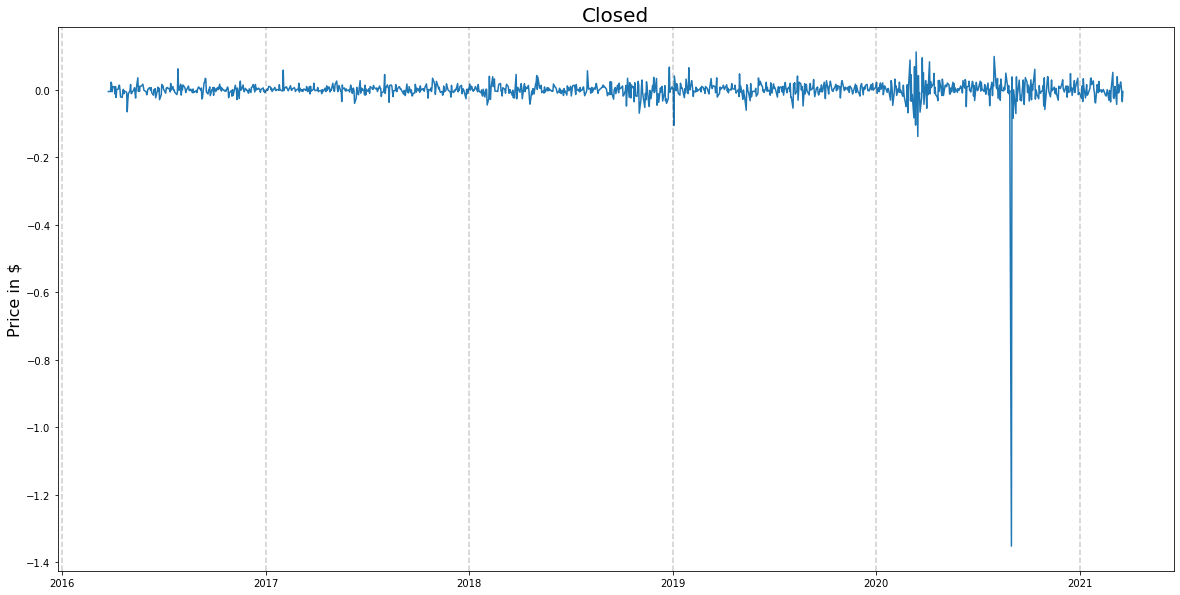

In [421]:
plt.figure(figsize=(20,10))
plt.plot(df2.FirstDifference)
plt.title('Closed', fontsize=20)
plt.ylabel('Price in $', fontsize=16)
for year in range(2016,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

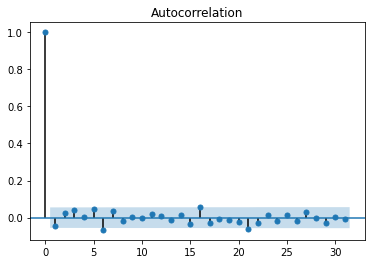

In [422]:
plot_acf(df2.FirstDifference)
plt.show()

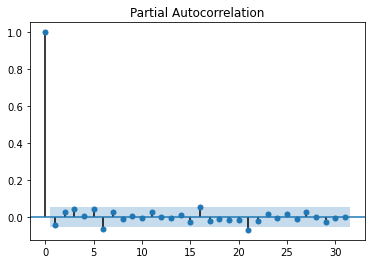

In [423]:
plot_pacf(df2.FirstDifference)
plt.show()

In [424]:
plt.figure(figsize=(20,10))
model = ARIMA(df2.FirstDifference.dropna(), order=(1,1,0))
result = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 1440x720 with 0 Axes>

In [425]:
fvalues = result.fittedvalues
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.FirstDifference   No. Observations:                 1255
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1925.078
Method:                       css-mle   S.D. of innovations              0.052
Date:                Tue, 25 May 2021   AIC                          -3844.156
Time:                        13:31:04   BIC                          -3828.752
Sample:                             1   HQIC                         -3838.366
                                                                              
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -8.393e-06      0.001     -0.009      0.993      -0.002       0.002
ar.L1.D.FirstDifference    -0.5342      0.024    -22.407      0.000      -0.581      -0.487
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.8720           +0.0000j            1.8720            0.5000
-----------------------------------------------------------------------------
"""

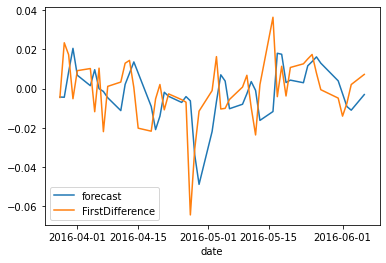

In [426]:
# result.plot_predict(start=1, end=50)
# plt.show()

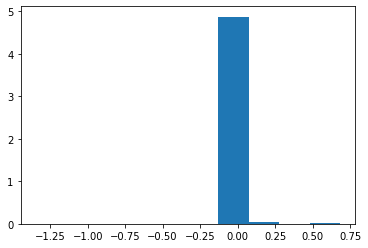

In [427]:
residual = result.resid
plt.hist(residual, density=True)
plt.show()

[]

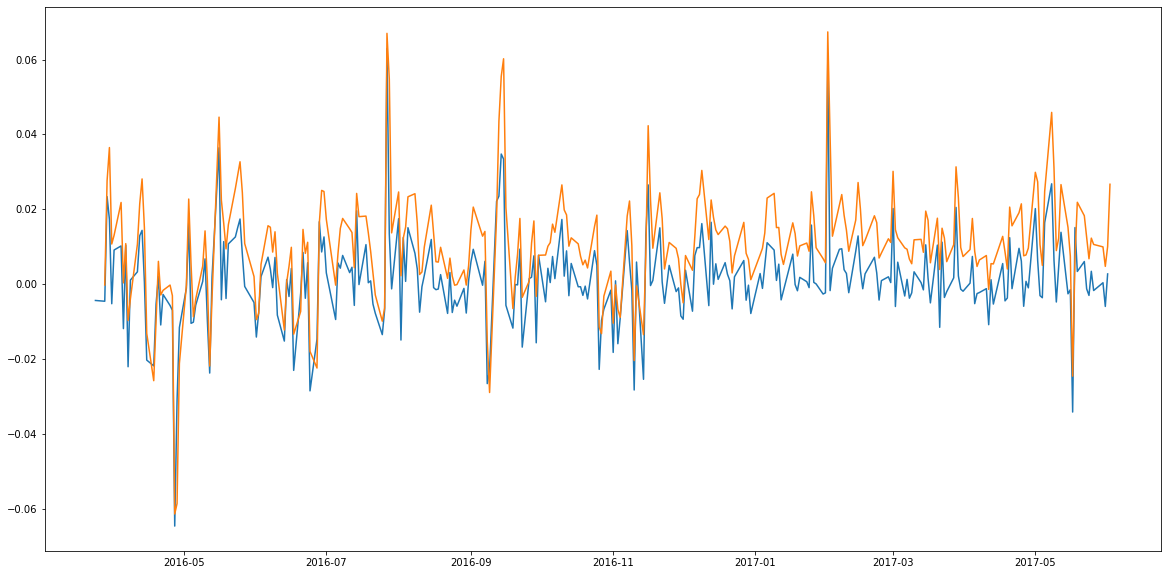

In [428]:
residual = residual.cumsum()
plt.figure(figsize=(20,10))
plt.plot(df2.FirstDifference[:300])
plt.plot(residual[:300])
plt.plot()

In [429]:
a = df2.close-df2.FirstDifference
diff_results = residual + residual.shift(-1)
diff_results = diff_results + a

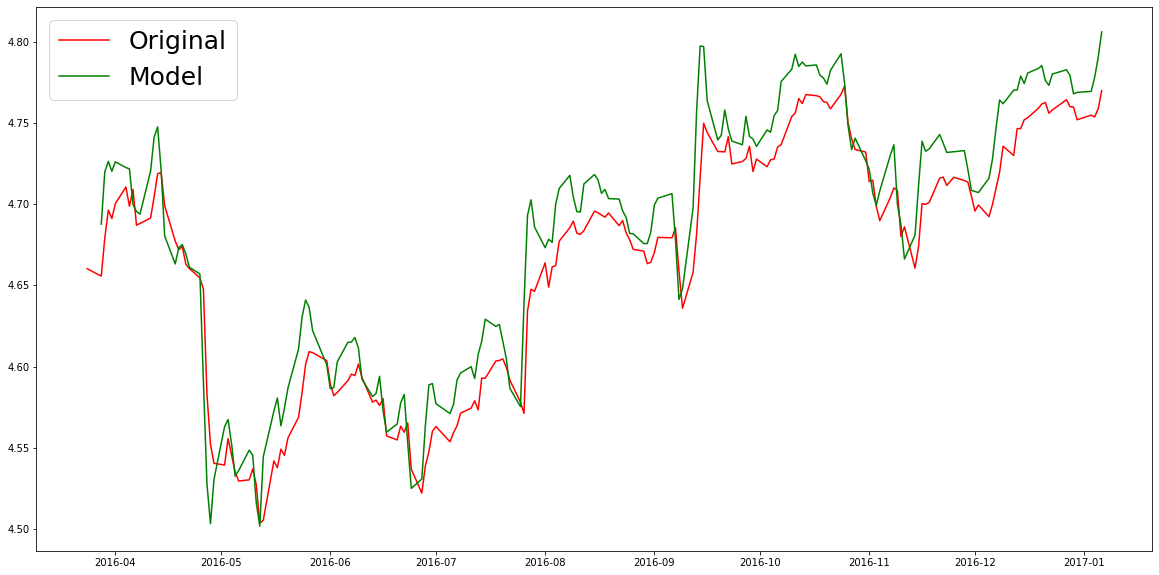

In [430]:
plt.figure(figsize=(20,10))
plt.plot(df2.iloc[:200].close, label='Original', color='red')
plt.plot(diff_results[:200], label='Model', color='green')
plt.legend(prop={'size':25})
plt.show()

In [431]:
df1 = diff_results

In [432]:
df1.dropna(inplace=True)

In [433]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [434]:
df1 = df1.reshape(1254)

In [435]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[:training_size],df1[training_size:]

In [436]:
len(train_data), len(test_data)

(815, 439)

In [437]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [438]:
X_train.shape, y_train.shape

((754, 60), (754,))

In [439]:
X_test.shape, y_test.shape

((378, 60), (378,))

In [440]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [441]:
len(X_train), len(y_train), len(X_test), len(y_test)

(754, 754, 378, 378)

In [442]:
model=Sequential()
model.add(LSTM(30, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

In [443]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 30)                3840      
_________________________________________________________________
dropout_19 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [444]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64,verbose=1)

Epoch 1/5
12/12 [==============================] - 2s 43ms/step - loss: 0.2012 - accuracy: 0.0000e+00 - val_loss: 0.1585 - val_accuracy: 0.0026
Epoch 2/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0387 - accuracy: 0.0000e+00 - val_loss: 0.0154 - val_accuracy: 0.0026
Epoch 3/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0159 - accuracy: 0.0000e+00 - val_loss: 0.0238 - val_accuracy: 0.0026
Epoch 4/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0275 - val_accuracy: 0.0026
Epoch 5/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0166 - val_accuracy: 0.0026


In [445]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [446]:
rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print(rmse)

0.12896736437831735


In [447]:
# final_train = pd.DataFrame(df2[:714])
# final_train['train'] = scaler.inverse_transform(train_predict)

In [448]:
# plt.figure(figsize=(20,10))
# plt.plot(final_train.close, label='Original')
# plt.plot(final_train.train, label='Trained')
# plt.legend()
# plt.show()


In [449]:
final_test = pd.DataFrame(df2[878:])

In [450]:
final_test

,close,FirstDifference
date,,
2019-09-19,5.397982,-0.008158
2019-09-20,5.383256,-0.014726
2019-09-23,5.387792,0.004537
2019-09-24,5.383026,-0.004766
2019-09-25,5.398298,0.015272
...,...,...
2021-03-15,4.820201,0.024162
2021-03-16,4.832863,0.012662
2021-03-17,4.826392,-0.006471


In [451]:
final_test['test'] = scaler.inverse_transform(test_predict)

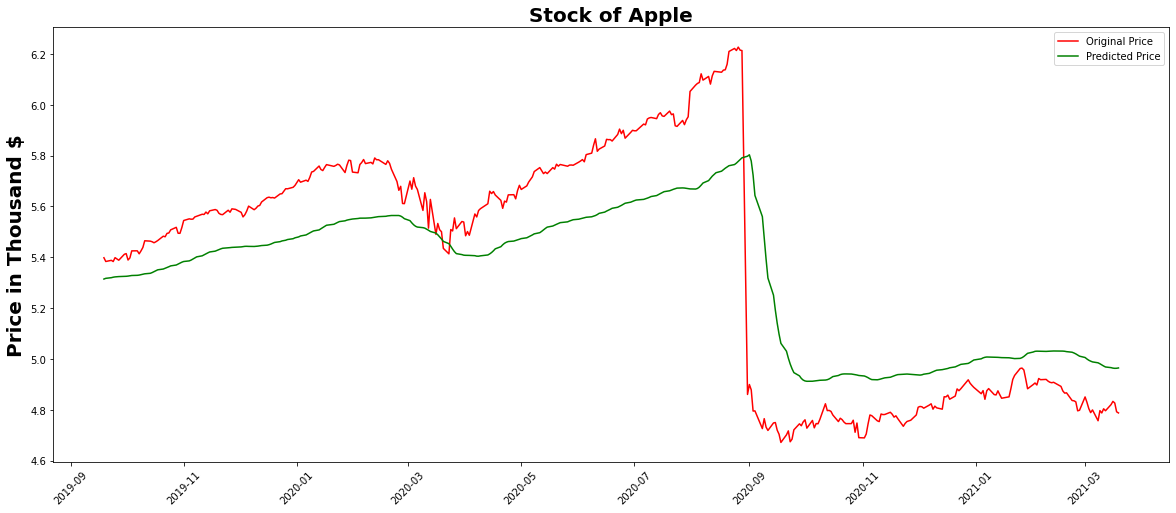

In [452]:
plt.figure(figsize=(20,8))
plt.plot(final_test.close, label='Original Price', color='red')
plt.plot(final_test.test, label='Predicted Price', color='green')
plt.title('Stock of Apple', fontweight='bold', fontsize=20)
plt.ylabel('Price in Thousand $', fontweight='bold', fontsize=20)
plt.legend()
plt.xticks(rotation=45)
plt.show()